### RNN

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import time

import sys
sys.path.insert(1, '/content/')

from data_utils import parse_imdb_sequence
tf.random.set_seed(20)

word2idx = pickle.load(open('./content/word2idx.pkl', 'rb'))

#### define model

In [2]:
class RNNModel(tf.keras.Model):
    def __init__(self, embedding_size=100, cell_size=64, dense_size=128,
                 num_classes=2, vocabulary_size=None, rnn_cell='lstm',
                 device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on and the checkpoint
            directory. Additionaly, you can also modify the default size of the 
            network.
            
            Args:
                embedding_size: the size of the word embedding.
                cell_size: RNN cell size.
                dense_size: the size of the dense layer.
                num_classes: the number of labels in the network.
                vocabulary_size: the size of the word vocabulary.
                rnn_cell: string, either 'lstm' or 'ugrnn'.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        '''
        super(RNNModel, self).__init__()

        # Weights initializer function
        w_initializer = tf.compat.v1.keras.initializers.glorot_uniform()
        # Biases initializer function
        b_initializer = tf.zeros_initializer()

        # Initialize weights for word embeddings 
        self.embeddings = tf.keras.layers.Embedding(vocabulary_size, embedding_size, 
                                                    embeddings_initializer=w_initializer)
        
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size, activation=tf.nn.relu, 
                                                 kernel_initializer=w_initializer, 
                                                 bias_initializer=b_initializer)
        # Predictions layer initialization
        self.pred_layer = tf.keras.layers.Dense(num_classes, activation=None, 
                                                kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer)
        
        # Basic LSTM cell
        if rnn_cell=='lstm':
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)
        # Else RNN cell
        else:
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(cell_size)
            
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory

    def predict(self, X, seq_length, is_training):
        '''
        Predicts the probability of each class, based on the input sample.

        Args:
            X: 2D tensor of shape (batch_size, time_steps).
            seq_length: the length of each sequence in the batch.
            is_training: Boolean. Either the network is predicting in
                         training mode or not.
        '''
        
        # Get the number of samples within a batch
        num_samples = tf.shape(X)[0]

        # Initialize LSTM cell state with zeros
        state = self.rnn_cell.zero_state(num_samples, dtype=tf.float32)
        
        # Get the embedding of each word in the sequence
        embedded_words = self.embeddings(X)
        
        # Unstack the embeddings
        unstacked_embeddings = tf.unstack(embedded_words, axis=1)
        
        # Iterate through each timestep and append the predictions
        outputs = []
        for input_step in unstacked_embeddings:
            output, state = self.rnn_cell(input_step, state)
            outputs.append(output)
            
        # Stack outputs to (batch_size, time_steps, cell_size)
        outputs = tf.stack(outputs, axis=1)
        
        # Extract the output of the last time step, of each sample
        idxs_last_output = tf.stack([tf.range(num_samples), 
                                     tf.cast(seq_length-1, tf.int32)], axis=1)
        final_output = tf.gather_nd(outputs, idxs_last_output)
        
        # Add dropout for regularization
        #dropped_output = tf.compat.v1.layers.Dropout(final_output, rate=0.3, training=is_training)
        
        # Pass the last cell state through a dense layer (ReLU activation)
        dense = self.dense_layer(final_output)
        
        # Compute the unnormalized log probabilities
        logits = self.pred_layer(dense)
        return logits
    
    def loss_fn(self, X, y, seq_length, is_training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(X, seq_length, is_training)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=preds)
        return loss

    
    def grads_fn(self, X, y, seq_length, is_training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(X, y, seq_length, is_training)
        return tape.gradient(loss, self.variables)

    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,1)))
            dummy_length = tf.constant(1, shape=(1,))
            dummy_pred = self.predict(dummy_input, dummy_length, False)
            # Restore the variables of the model
            saver = tf.compat.v1.train.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    

    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.compat.v1.train.Saver(self.variables).save(save_path=self.checkpoint_directory, 
                                       global_step=global_step)
        
    
    def fit(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the accuracy on the eval 
                                       dataset does not increase after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best_acc. This variable will store the highest accuracy
        # on the eval dataset.
        best_acc = 0
        
        # Initialize classes to update the mean accuracy of train and eval
        train_acc = tf.keras.metrics.Accuracy('train_acc')
        eval_acc = tf.keras.metrics.Accuracy('eval_acc')
        
        # Initialize dictionary to store the accuracy history
        self.history = {}
        self.history['train_acc'] = []
        self.history['eval_acc'] = []
        self.history['train_epoch_time'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                start_time = time.time()

                # Training with gradient descent
                for step, (X, y, seq_length) in enumerate(training_data):
                    grads = self.grads_fn(X, y, seq_length, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                
                end_time = time.time()
                self.history['train_epoch_time'].append(end_time - start_time)

                # Check accuracy train dataset
                for step, (X, y, seq_length) in enumerate(training_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    train_acc(preds, y)
                self.history['train_acc'].append(train_acc.result().numpy())
                # Reset metrics
                train_acc.reset_states()

                # Check accuracy eval dataset
                for step, (X, y, seq_length) in enumerate(eval_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    eval_acc(preds, y)
                self.history['eval_acc'].append(eval_acc.result().numpy())
                # Reset metrics
                eval_acc.reset_states()
                
                # Print train and eval accuracy
                if (i==0) | ((i+1)%verbose==0):
                    print('Train accuracy at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    print('Eval accuracy at epoch %d: ' %(i+1), self.history['eval_acc'][-1])

                # Check for early stopping
                if self.history['eval_acc'][-1]>best_acc:
                    best_acc = self.history['eval_acc'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break

#### prepare the data

In [14]:
batch_size = 512

train_dataset = tf.data.TFRecordDataset('./content/train.tfrecords')
train_dataset = train_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
train_dataset = train_dataset.padded_batch(batch_size, padded_shapes=([None],[],[]))

test_dataset = tf.data.TFRecordDataset('./content/test.tfrecords')
test_dataset = test_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
test_dataset = test_dataset.padded_batch(batch_size, padded_shapes=([None],[],[]))



#### model training with vanilla RNN cells


In [15]:
checkpoint_directory = './hw5/models/checkpoints'

device='gpu:0'
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3)

rnn_model = RNNModel(vocabulary_size=len(word2idx), device=device,
                     checkpoint_directory=checkpoint_directory)

rnn_model.fit(train_dataset, test_dataset, optimizer,
              num_epochs=10, early_stopping_rounds=5, verbose=1, 
              train_from_scratch=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.85568
Eval accuracy at epoch 1:  0.8202
Train accuracy at epoch 2:  0.94028
Eval accuracy at epoch 2:  0.87756
Train accuracy at epoch 3:  0.96044
Eval accuracy at epoch 3:  0.8792
Train accuracy at epoch 4:  0.95076
Eval accuracy at epoch 4:  0.84424
Train accuracy at epoch 5:  0.92456
Eval accuracy at epoch 5:  0.80228
Train accuracy at epoch 6:  0.983
Eval accuracy at epoch 6:  0.86244
Train accuracy at epoch 7:  0.99044
Eval accuracy at epoch 7:  0.86768
Train accuracy at epoch 8:  0.99296
Eval accuracy at epoch 8:  0.86104


In [16]:
checkpoint = tf.train.Checkpoint(rnn_model)
save_path = checkpoint.save(checkpoint_directory)

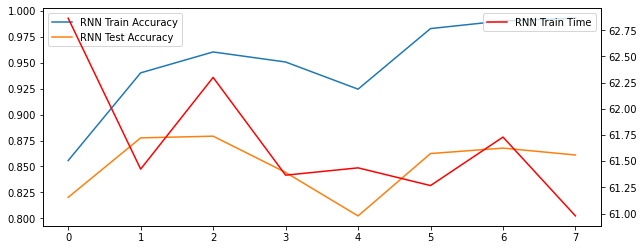

In [17]:
f, ax = plt.subplots(figsize=(10, 4))
ax.plot(range(len(rnn_model.history['train_acc'])), rnn_model.history['train_acc'], 
         label='RNN Train Accuracy');
ax.plot(range(len(rnn_model.history['eval_acc'])), rnn_model.history['eval_acc'], 
         label='RNN Test Accuracy');
# ax.set_ylim(0.5,1)

ax1 = ax.twinx()
ax1.plot(range(len(rnn_model.history['train_epoch_time'])), rnn_model.history['train_epoch_time'], 'r-',
         label='RNN Train Time');

ax.legend();
ax1.legend();

In [18]:
np.mean(rnn_model.history['train_epoch_time'])

61.67069345712662

### BERT

In [3]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 7.0 MB/s 
     |████████████████████████████████| 462 kB 48.4 MB/s 
     |████████████████████████████████| 1.8 MB 7.9 MB/s 
     |████████████████████████████████| 1.1 MB 40.5 MB/s 
     |████████████████████████████████| 1.2 MB 32.7 MB/s 
     |████████████████████████████████| 237 kB 50.3 MB/s 
     |████████████████████████████████| 47.8 MB 2.1 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 596 kB 36.3 MB/s 
     |████████████████████████████████| 352 kB 45.4 MB/s 
     |████████████████████████████████| 99 kB 9.2 MB/s 
     |████████████████████████████████| 90 kB 8.5 MB/s 


In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

#### load dataset

In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84140032/84125825 [==============================] - 1s 0us/step


In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'What an entertaining movie. Astaire and Randolph Scott are in the Navy. Astaire has to woo back Ginger in San Francisco, while Scott must be persuaded that Harriet Hilliard is worthy of being his wife. Everything works out fine.<br /><br />It\'s sometimes argued, and I can see why, that Scott\'s romance with Hilliard is unnecessary and slows the plot down. Especially painful are Hilliard\'s singing of sappy love songs. I could have done without her singing, right enough, but I found the romance rather touching. Hilliard enters the movie as a music teacher, wearing a pair of spectacles, no makeup, and the ugliest clothes known to man or beast. No wonder Scott avoids her until she grooms herself sexily under the tutelage of her sister Ginger and a slinky Lucille Ball. The problem is that AFTER her makeover she looks like the same irretrievably plain woman as before, only with a glossier outfit. It\'s tough enough for a homely guy. But at least a man can become wealthy and power

#### define model

In [8]:
class TransformerModel(tf.keras.Model):
    def __init__(self, bert_model_name, tfhub_handle_encoder, tfhub_handle_preprocess):
        super(TransformerModel, self).__init__()
        
        self.bert_model_name = bert_model_name
        self.tfhub_handle_encoder = tfhub_handle_encoder
        self.tfhub_handle_preprocess = tfhub_handle_preprocess
    
        self.preprocessing_layer = hub.KerasLayer(self.tfhub_handle_preprocess, name='preprocessing')
        self.encoder_layer = hub.KerasLayer(self.tfhub_handle_encoder, trainable=True, name='BERT_encoder')
        self.dropout_layer = tf.keras.layers.Dropout(0.1)
        self.output_layer = tf.keras.layers.Dense(1, activation=None, name='classifier')
    

    def call(self, text_input):
        encoder_inputs = self.preprocessing_layer(text_input)
        encoder_output = self.encoder_layer(encoder_inputs)
        net = encoder_output['pooled_output']
        x = self.dropout_layer(net)
        x = self.output_layer(x)

        return x


#### train model

In [10]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

classifier = TransformerModel(bert_model_name, tfhub_handle_encoder, tfhub_handle_preprocess)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 1e-5
# optimizer = optimization.create_optimizer(init_lr=init_lr,
#                                           num_train_steps=num_train_steps,
#                                           num_warmup_steps=num_warmup_steps,
#                                           optimizer_type='adamw')
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)

classifier.compile(optimizer=optimizer,
                   loss=loss_fn,
                   metrics=metrics)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
print(f'Training model with {tfhub_handle_encoder}')

start_time = time.time()
history = classifier.fit(x=train_ds,
                         validation_data=val_ds,
                         epochs=epochs,
                         callbacks=[callback])
end_time = time.time()


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10
625/625 [==============================] - 150s 224ms/step - loss: 0.4896 - binary_accuracy: 0.7419 - val_loss: 0.3910 - val_binary_accuracy: 0.8110
Epoch 2/10
625/625 [==============================] - 138s 220ms/step - loss: 0.3755 - binary_accuracy: 0.8219 - val_loss: 0.3654 - val_binary_accuracy: 0.8316
Epoch 3/10
625/625 [==============================] - 137s 219ms/step - loss: 0.3277 - binary_accuracy: 0.8504 - val_loss: 0.3700 - val_binary_accuracy: 0.8334
Epoch 4/10
625/625 [==============================] - 137s 219ms/step - loss: 0.2899 - binary_accuracy: 0.8680 - val_loss: 0.3642 - val_binary_accuracy: 0.8488
Epoch 5/10
625/625 [==============================] - 137s 219ms/step - loss: 0.2544 - binary_accuracy: 0.8890 - val_loss: 0.3784 - val_binary_accuracy: 0.8476
Epoch 6/10
625/625 [==============================] - 138s 220ms/step - loss: 0.2208 - binary_accuracy: 0.90

In [13]:
loss, accuracy = classifier.evaluate(test_ds)
print(f'Accuracy: {accuracy}')

time_per_epoch = (end_time - start_time) / 7
print(f'Average time per epoch: {time_per_epoch}')

782/782 [==============================] - 105s 134ms/step - loss: 0.4068 - binary_accuracy: 0.8457
Accuracy: 0.8456799983978271
Average time per epoch: 141.36438008717127


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


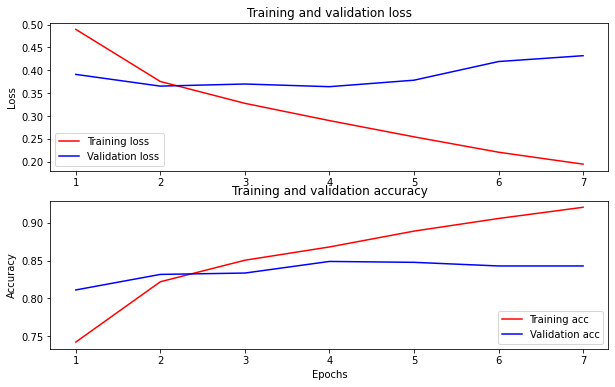

In [12]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')